In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
       
from scipy.stats import norm
from warnings import filterwarnings
filterwarnings('ignore')


In [620]:
class delta_hedging:

    def __init__(self, input):
 
        self.s0         = input['s0']               # 현재가격
        self.k          = input['k']                # 행사가격
        self.rf         = input['rf']               # 무위험이자율
        self.sigma      = input['sigma']            # 변동성
        self.mu         = input['mu']               # 평균수익률
        self.T          = input['T']                # 투자기간
        self.q          = input['q']                # 배당금 

        self.interval   = input['interval']         # T의 기간 텀
        self.time_step  = input['time_step']        # Investment Horizon
        self.simul      = input['simul_num']        # 시뮬레이션 횟수

        if self.interval == 'weekly':               
            self.dt = self.T / 52                   
        elif self.interval == 'daily':
            self.dt = self.T / 255
        
        self.tau        = self.time_step * self.dt
        self.tau_arr    = np.flip(np.arange(0, self.time_step+1)) * self.dt
        self.rf_arr     = np.exp(np.flip(np.arange(0, self.time_step+1)) * self.dt * self.rf)


    def bs_call(self):
        d1 = (np.log(self.s0/self.k) +((self.rf - self.q +0.5*np.power(self.sigma, 2))*self.tau))/(self.sigma*np.sqrt(self.tau))
        d2 = d1 - self.sigma*np.sqrt(self.tau)
        value = self.s0*norm.cdf(d1) - self.k*np.exp(-self.rf*self.tau)*norm.cdf(d2)
        return value


    def stock_path(self):

        value = np.ones((2, self.simul)) * self.s0

        for idx in range(1, self.T * self.time_step + 1):
            d_term = (self.mu - self.q - 0.5 * self.sigma**2) * self.dt
            s_term = self.sigma * np.sqrt(self.dt) * np.random.normal(size=(self.simul))

            value = np.vstack([value, value[-1] * np.exp(d_term + s_term)])
            
        value = value[1:]

        return value

    def d1_cal (self, s, k, q, sigma, rf, dt):

        return  (np.log(s/k) +((rf - q + 0.5 * np.power(sigma, 2))*dt))/(sigma*np.sqrt(dt))

    def path_delta (self, stock_path=None):
        '''path is generated by stock_path'''

        if stock_path is None:
            path = self.stock_path()
        else:
            path = stock_path

        d1 = (np.log(self.stock_path()/self.k) + (self.rf - self.q + 0.5*self.sigma**2)*self.tau_arr.reshape(-1,1)) / (self.sigma * np.sqrt(self.tau_arr.reshape(-1,1)))

        delta = norm.cdf(d1)
 
        return delta

    def path_delta_shares (self, path_delta=None):
        '''path_delta is created by path_delta'''
        # 첫 델타를 미뤄 미래의 델타를 만들고, 미래의 델타 - 현재의 델타 후에, initial delta 값 넣어주기

        if path_delta is None:
            path = self.path_delta()
        else:
            path = path_delta

        path_c = path[1:] - path[:-1]
        path = np.vstack([path[0], path_c])

        return path
    
    def path_cost (self, stock_path=None, path_delta_shares=None):
        '''first, stock_path, second path_delta_shares'''

        if stock_path is not None and path_delta_shares is not None:
            path = stock_path
            path_delta_share = path_delta_shares
        else:
            path = self.stock_path()
        
        path_delta_share = self.path_delta_shares(path)

        return path * path_delta_share

    def delta_hedging_cost (self, path=None):
        '''Input Cost Path or Not'''
        if path is not None:
            path_cost = path
        else:
            path_cost = self.path_cost()

        delta_hedging_cost = self.rf_arr @ path_cost
        
        delta_hedging_cost = np.where(delta_hedging_cost > self.k, delta_hedging_cost - self.k, delta_hedging_cost)

        return delta_hedging_cost

In [621]:
'''Parameters'''
inputs = {
    's0' : 49,
    'k' : 50,
    'rf' : 0.05,
    'sigma' : 0.2,
    'T' : 1,
    'mu' : 0.13,
    'q' : 0,
    'interval' : 'weekly',
    'time_step' : 20,
    'simul_num' : 1000
}

In [622]:
a = delta_hedging(inputs)
a.stock_path()

array([[49.        , 49.        , 49.        , ..., 49.        ,
        49.        , 49.        ],
       [48.61328339, 48.39069016, 49.16950466, ..., 45.83702287,
        51.1958728 , 48.62411726],
       [45.53996103, 48.94756531, 49.28024282, ..., 47.13190445,
        50.74481261, 50.90646575],
       ...,
       [53.04741521, 47.32520868, 55.69331902, ..., 42.20073781,
        48.06995136, 44.01536831],
       [51.88889609, 47.86075139, 56.88736128, ..., 42.59110304,
        48.45417134, 42.73465044],
       [51.82101261, 49.63626085, 60.32173478, ..., 42.1833304 ,
        48.31863661, 42.43410174]])

In [623]:
a.delta_hedging_cost().mean()

2597.0124826825468

In [463]:
a = delta_hedging(inputs)
path_cost =a.path_cost()
rf_arr = np.exp(np.flip(np.arange(0, a.time_step+1)) * a.dt * a.rf)

tmp = path_cost * rf_arr.reshape(-1,1)
ending_tmp = tmp.cumsum(axis=0)[-1,:]
np.where(ending_tmp > 50, ending_tmp - 50, ending_tmp).mean()


13.607094174189568

In [390]:
ending_tmp = tmp.cumsum(axis=1)[-1,:]
np.where(ending_tmp > 50, ending_tmp - 50, ending_tmp).mean()


-44.44263711218593

In [ ]:
ending_tmp()

In [129]:
np.round(a.path_delta(),3)

array([[0.522, 0.522, 0.522, ..., 0.522, 0.522, 0.522],
       [0.421, 0.56 , 0.657, ..., 0.637, 0.596, 0.483],
       [0.297, 0.551, 0.625, ..., 0.596, 0.545, 0.401],
       ...,
       [1.   , 1.   , 1.   , ..., 0.664, 0.004, 0.003],
       [0.999, 1.   , 1.   , ..., 0.25 , 0.   , 0.   ],
       [1.   , 1.   , 1.   , ..., 1.   , 0.   , 0.   ]])

In [26]:
m = 1000;mu = 0.13;r = 0.05;S0 = 49;K = 50;sigma = 0.2;imvol = 0.2; timeSteps=20; dt=1/52
mean_w, std_w, hedge_cost_w, delta_w ,St_w = get_mean_std(m, timeSteps, dt, r, sigma, K, S0, mu, imvol)

TypeError: standard_normal() got an unexpected keyword argument 'random_state'

In [553]:
tau_arr = np.flip(np.arange(0, a.time_step+1))
d1_ = (np.log(a.stock_path()/a.k) + (a.rf - a.q + 0.5*a.sigma**2)*tau_arr.reshape(-1,1)) / (a.sigma * np.sqrt(tau_arr.reshape(-1,1)))

delta = norm.cdf(d1_)
delta_c = delta[1:] - delta[:-1]
path_delta = np.vstack([delta[0], delta_c])

In [554]:
path_delta

array([[ 0.93854339,  0.93854339,  0.93854339, ...,  0.93854339,
         0.93854339,  0.93854339],
       [-0.00314984, -0.00381921, -0.01105482, ..., -0.01245724,
        -0.00371847, -0.0088282 ],
       [-0.0043164 ,  0.00229145, -0.00985937, ..., -0.00859549,
        -0.00270089, -0.0106865 ],
       ...,
       [-0.05112327, -0.04711897, -0.03058801, ..., -0.09423097,
        -0.00874125, -0.12809825],
       [-0.08820645, -0.03704019, -0.06256184, ..., -0.08685277,
         0.03825795, -0.14014503],
       [-0.62095125,  0.34829491, -0.55598827, ..., -0.46931405,
         0.13867933, -0.31047486]])

In [551]:
delta[1] - delta[0]

array([-6.74943594e-03, -5.48584907e-03, -3.29813076e-03,  5.00479475e-04,
       -2.63853184e-03, -7.03410390e-03, -9.81526261e-03, -1.20439951e-02,
       -5.46395256e-03, -2.45992314e-03, -2.68238194e-03, -1.98395666e-03,
       -8.28908705e-04, -8.42136616e-03, -4.64963001e-03, -5.27773157e-03,
       -1.14636540e-02, -7.25265003e-03, -6.59768985e-03, -3.71741183e-03,
       -2.23783139e-03, -1.01405422e-02, -7.19667682e-03, -1.19649356e-03,
       -1.07139227e-03, -6.62610763e-03, -1.54761212e-02, -7.13400597e-03,
       -1.14742835e-02, -3.11943656e-03, -4.83811847e-03, -5.79584654e-03,
       -1.43791754e-03, -6.90823177e-03, -1.33121185e-03, -4.07037225e-03,
       -5.98842871e-03, -4.96301297e-06, -8.59142091e-03, -5.00421987e-03,
       -5.10164201e-03, -2.70816766e-03, -2.26856089e-03, -8.65574260e-03,
       -1.15511981e-02, -5.69823876e-03, -3.90926301e-03, -3.50805900e-03,
       -1.05326886e-03,  3.22170924e-04, -4.06635102e-03, -1.04170235e-02,
       -5.20180716e-03, -

In [505]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt

m = 1000
mu = 0.13
r = 0.05
S0 = 49
K = 50
sigma = 0.2
imvol = 0.2

def get_mean_std(m, timeSteps, dt, r, sigma, K, S0, mu, imvol):
    
    np.random.seed(111)
    # drift term
    drift = (mu-0.5*sigma**2)*dt

    # diffusion term
    z = np.random.normal(size=(m,timeSteps))
    diffusion = (sigma*np.sqrt(dt)*z)

    # generating St
    p = drift + diffusion
    cm = np.exp(np.cumsum(p,axis=1))

    St = S0*cm

    S0_arr = np.repeat(S0,m).reshape(m,1)
    St_arr = np.append(S0_arr, St, axis=1)

    # generating tau
    tau = (timeSteps - np.arange(timeSteps+1).reshape(1,-1))*dt

    # generating delta
    d1 = (np.log(St_arr/K) +((r+0.5*np.power(imvol, 2))*tau))/(imvol*np.sqrt(tau))
    delta = scipy.stats.norm.cdf(d1)
    delta_chg = delta[:,1:] - delta[:,:-1]
    delta_chg_arr = np.append(delta[:,0].reshape(-1,1),delta_chg, axis=1)

    hedge_cost = (delta_chg_arr*St_arr*(np.exp(r*tau))) #.cumsum(axis=1)[:,-1]
    hedge_cost[np.where(hedge_cost>K)] = hedge_cost[np.where(hedge_cost>K)] - K

    #simulation mean
    mean = np.mean(hedge_cost)

    #simulation standard error
    std = np.std(hedge_cost)

    return mean, std, St_arr, hedge_cost, delta, delta_chg_arr, tau

def get_hedge_cost(period):

    if period == 'weekly':

        timeSteps = 20
        dt = 1/52

        mean_weekly = get_mean_std(m, timeSteps, dt, r, sigma, K, S0, mu, imvol)[0]
        std_weekly = get_mean_std(m, timeSteps, dt, r, sigma, K, S0, mu, imvol)[1]

        print('mean_weekly : ', mean_weekly)
        print('std_weekly : ', std_weekly)

    else:
        timeSteps = 100
        dt = 1/260

        mean_daily = get_mean_std(m, timeSteps, dt, r, sigma, K, S0, mu, imvol)[0]
        std_daily = get_mean_std(m, timeSteps, dt, r, sigma, K, S0, mu, imvol)[1]

        print('mean_daily : ', mean_daily)
        print('std_daily : ', std_daily)

In [72]:
get_hedge_cost('weekly')

mean_weekly :  2.4581920356066234
std_weekly :  0.4944599193964492


In [110]:
get_mean_std(m, timeSteps, dt, r, sigma, K, S0, mu, imvol)[2].shape

(1000, 20)

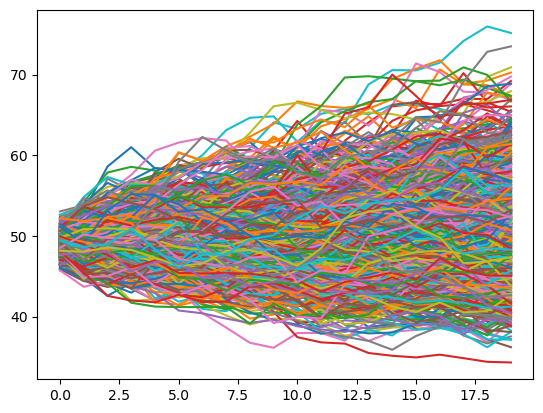

In [117]:
plt.plot(get_mean_std(m, timeSteps, dt, r, sigma, K, S0, mu, imvol)[2].T)
plt.show()

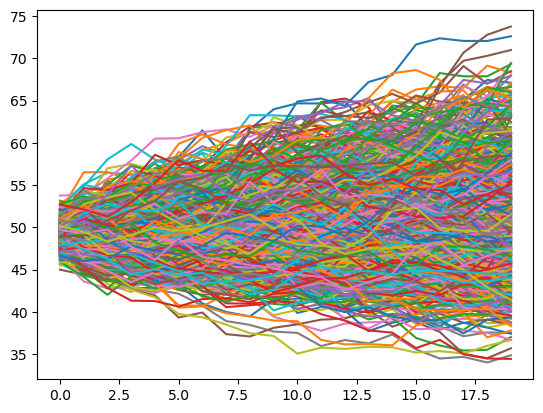

In [118]:
plt.plot(a.stock_path()[1:])
plt.show()

In [514]:
get_mean_std(m, timeSteps, dt, r, sigma, K, S0, mu, imvol)[3].cumsum(axis=1)

array([[26.054897  , 21.20162753, 22.97408505, ...,  2.34440747,
         2.55400746,  2.11724292],
       [26.054897  , 24.36202722, 24.1582283 , ..., 35.01992204,
         9.19322458,  2.76282369],
       [26.054897  , 20.49272095, 21.28738818, ..., 52.84027412,
        52.84030005, 52.84030005],
       ...,
       [26.054897  , 28.05490365, 19.24609893, ...,  3.54193653,
         3.52775994,  3.52775982],
       [26.054897  , 23.03547644, 22.40889642, ...,  5.38701296,
         3.84585427,  3.35852294],
       [26.054897  , 27.30934303, 24.45641518, ..., 52.59005961,
        52.59161331, 52.59211513]])

In [532]:
que2 = get_mean_std(m, timeSteps, dt, r, sigma, K, S0, mu, imvol)[3].cumsum(axis=1)[:,-1]
np.where(que2 > K, que2-K, que2)

array([2.11724292, 2.76282369, 2.84030005, 1.33008826, 2.52497307,
       1.77414994, 2.29850843, 2.44052062, 2.66065418, 2.67194753,
       2.79835053, 2.04829552, 2.20996178, 2.15481524, 2.1771928 ,
       1.97878829, 2.57898694, 2.79909611, 2.56522695, 3.35086683,
       2.83813146, 2.90025504, 3.36861416, 2.77011161, 2.46220973,
       2.55849188, 1.6834581 , 2.46779188, 2.59392756, 3.09599232,
       2.83778638, 2.40274454, 2.1712552 , 1.41857188, 2.68661688,
       1.77673944, 2.97204722, 2.4170981 , 1.5148937 , 2.75555817,
       2.59777442, 2.53046632, 2.48400892, 3.5034982 , 1.8954633 ,
       2.33167245, 1.74228662, 2.33948709, 2.38558253, 2.62431767,
       2.167523  , 1.72375362, 2.43785921, 2.26730305, 2.4184426 ,
       3.55912884, 3.0166653 , 2.48269837, 2.53445444, 1.00496812,
       2.48818502, 2.63715368, 2.2183851 , 2.45584957, 2.27078812,
       1.98498554, 2.27608504, 2.56510059, 2.45483211, 2.88705422,
       2.32326048, 2.94670755, 2.62262492, 2.65903257, 1.63713

In [533]:
(rf_arr.reshape(-1,1) * path_cost).cumsum(axis=0)[-1]

array([ 4.69367377e+01, -6.14024719e-01,  4.86246846e+01,  1.70140851e+00,
       -1.21108254e+00,  5.34738463e+01,  5.14792805e+01,  4.84859981e+01,
        4.78376827e+01,  4.99100671e+01,  9.44524778e-02,  4.93610877e+01,
        4.69820664e-01,  5.24277228e+01,  4.98605841e+01,  5.72016367e+01,
        2.41920815e+00, -9.04415292e-01,  4.65434756e+01,  5.13741229e+01,
       -1.86245373e+00,  5.51955815e+01,  5.10551024e+01,  5.08456882e+01,
        4.50563467e+00,  4.98424653e+01,  6.82782056e-01,  5.03797246e+01,
        5.25885524e+01,  5.02934724e+01, -5.36249419e-01,  5.00781819e+01,
        5.07252317e+01,  5.10671656e+01, -1.51876192e-01,  7.93297044e-01,
        5.06230664e+01,  1.32581212e-01, -1.99954297e+00,  5.06035740e+01,
        4.63627308e-01,  5.22766423e+01,  5.01717491e+01, -2.38033682e+00,
        1.20948161e+00,  1.23144653e+00,  4.96212466e+01,  5.06607020e+01,
        5.01383354e+01,  4.65578707e+01,  2.45868010e-01,  5.33818710e+01,
        4.94343647e+01,  

In [517]:
a = delta_hedging(inputs)
path_cost =a.path_cost()

rf_arr = np.exp(np.flip(np.arange(0, a.time_step+1)) * a.dt * a.rf)

(rf_arr.reshape(-1,1) * path_cost).cumsum(axis=0)

array([[26.054897  , 26.054897  , 26.054897  , ..., 26.054897  ,
        26.054897  , 26.054897  ],
       [32.79723275, 25.71438093, 28.12404425, ..., 36.82728531,
        31.33696342, 17.48446564],
       [34.00751493, 21.59577087, 29.80290807, ..., 38.98448392,
        32.43684532, 19.83521722],
       ...,
       [32.25874165, -0.6140247 , 48.62395827, ...,  1.76770932,
        46.51752992,  4.67890285],
       [41.74756868, -0.61402472, 48.6246846 , ...,  7.803577  ,
        46.03963341,  0.31798145],
       [46.93673767, -0.61402472, 48.6246846 , ..., -0.15521138,
        49.68762209,  0.20099731]])

In [527]:
que = (rf_arr.reshape(-1,1) * path_cost).cumsum(axis=0)[-1]
np.where(que > a.k, que - a.k, que).mean()

13.246056461460144